In [1]:
from pycocotools.coco import COCO

import os
import cv2
from PIL import Image
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
# define utils

label_list = {'0': 'General trash', '1': 'Paper', '2': 'Paper pack', '3': 'Metal', '4': 'Glass', '5': 'Plastic', '6': 'Styrofoam', '7': 'Plastic bag', '8': 'Battery', '9': 'Clothing'}

hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB')
def hex2rgb(h):
    return tuple(int(h[1+i:1+i+2], 16) for i in (0, 2, 4))
palette = [hex2rgb('#'+c) for c in hex]

def get_patch(annotation):
    patch = patches.Rectangle((annotation[0], annotation[1]), annotation[2], annotation[3], edgecolor='red', fill=False)
    return patch

def get_text_loc(annotation):
    return (annotation[0], annotation[1]-30)

def get_bbox(anno):
    tmp = []
    for i in range(len(anno)):
        tmp.append(anno[i]['bbox'])
    return tuple(tmp)

def get_cat(anno):
    tmp = []
    for i in range(len(anno)):
        tmp.append(label_list[str(anno[i]['category_id'])])
    return tmp

def draw_bbox(frame, boxes, labels):
    '''
    Draw bounding box
    '''
    for box, label in zip(boxes, labels):
        # draw rectangle on frame
        box = list(map(int, box))
        color_idx = [int(k) for k, v in label_list.items() if v == label][0]
        cv2.rectangle(frame, (box[0], box[1]), (box[2]+box[0], box[3]+box[1]), palette[color_idx], thickness=4)

        # show scores and labels
        (w1, h1), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)
        
        cv2.rectangle(frame, (box[0], box[1]-10-h1), (box[0]+w1, box[1]), palette[color_idx], -1)
        cv2.putText(frame, label, (box[0], box[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv2.LINE_AA)
    return frame

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
(1024, 1024, 3)
['Clothing', 'Clothing', 'Plastic bag', 'Clothing', 'Metal']


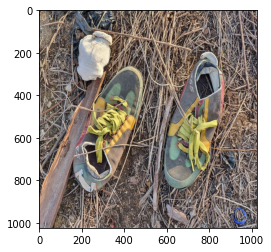

In [3]:
anno_root = '/opt/ml/detection/dataset/train.json' # annotation root
data_dir = '/opt/ml/detection/dataset' # data directory root

coco = COCO(anno_root)
predictions = {
    "images": coco.dataset["images"].copy(),
    "categories": coco.dataset["categories"].copy(),
    "annotations": None
}

idx = 14
image_id = coco.getImgIds(imgIds=idx) # get image Id -> list로도 가능
image_info = coco.loadImgs(image_id)[0] # dict 형태로 width, height, file_name, id를 load
anno_ids = coco.getAnnIds(imgIds=image_info['id'])
anno = coco.loadAnns(anno_ids)

image = cv2.imread(os.path.join(data_dir, image_info['file_name']))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
print(get_cat(anno))
plt.imshow(image)
plt.show()

In [4]:
cats = coco.dataset["categories"].copy()
print(cats)

[{'id': 0, 'name': 'General trash', 'supercategory': 'General trash'}, {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'}, {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'}, {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'}, {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'}, {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'}, {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}, {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}, {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'}, {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}]


defaultdict(None, {'General trash': 2105, 'Paper': 1714, 'Paper pack': 642, 'Metal': 598, 'Glass': 340, 'Plastic': 1369, 'Styrofoam': 512, 'Plastic bag': 1893, 'Battery': 46, 'Clothing': 229})
9448


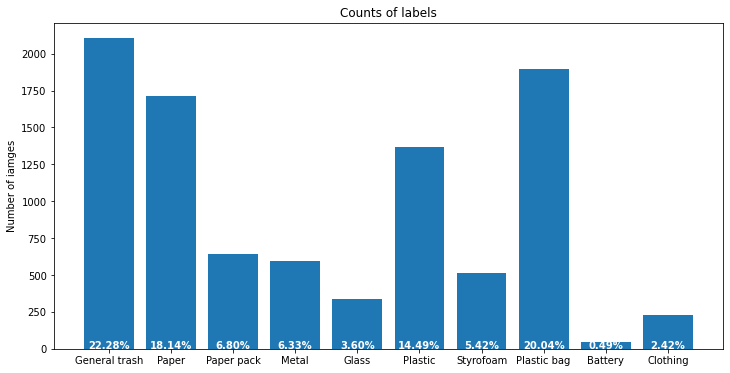

In [5]:
cats = coco.dataset["categories"].copy()

labels = defaultdict()
for i in range(len(cats)):
    imgIds = coco.getImgIds(catIds=i)
    labels[cats[i]['name']] = len(imgIds)
total = sum(labels.values())
print(labels)
print(total)

keys = [k for k in labels.keys()]
counts = [v for v in labels.values()]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(keys, counts)

plt.xticks(np.arange(10), labels.keys())
plt.title('Counts of labels')
plt.xlabel('')
plt.ylabel('Number of iamges')

counts_pct = [f'{elem/total * 100:.2f}%' for elem in counts]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment='center', size=10, color='w', fontweight='bold')
plt.show()

In [6]:
anno_root = '/opt/ml/detection/dataset/train.json' # annotation root
data_dir = '/opt/ml/detection/dataset' # data directory root

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_annos, image_labels = [], [], []
for i in range(len(images)):
    image_info = coco.loadImgs(i)[0]
    image_paths.append(os.path.join(data_dir, image_info['file_name']))
    anno_ids = coco.getAnnIds(imgIds=image_info['id'])
    anno = coco.loadAnns(anno_ids)
    image_annos.append(get_bbox(anno))

box_sizes = []
for j in range(1, len(image_annos)):
    for bbox in image_annos[j]:
        box_sizes.append(float(bbox[2]*bbox[3]))
print(max(box_sizes), np.sqrt(max(box_sizes)))
print(min(box_sizes), np.sqrt(min(box_sizes)))

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
1048371.21 1023.9
0.5599999999999999 0.7483314773547882


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


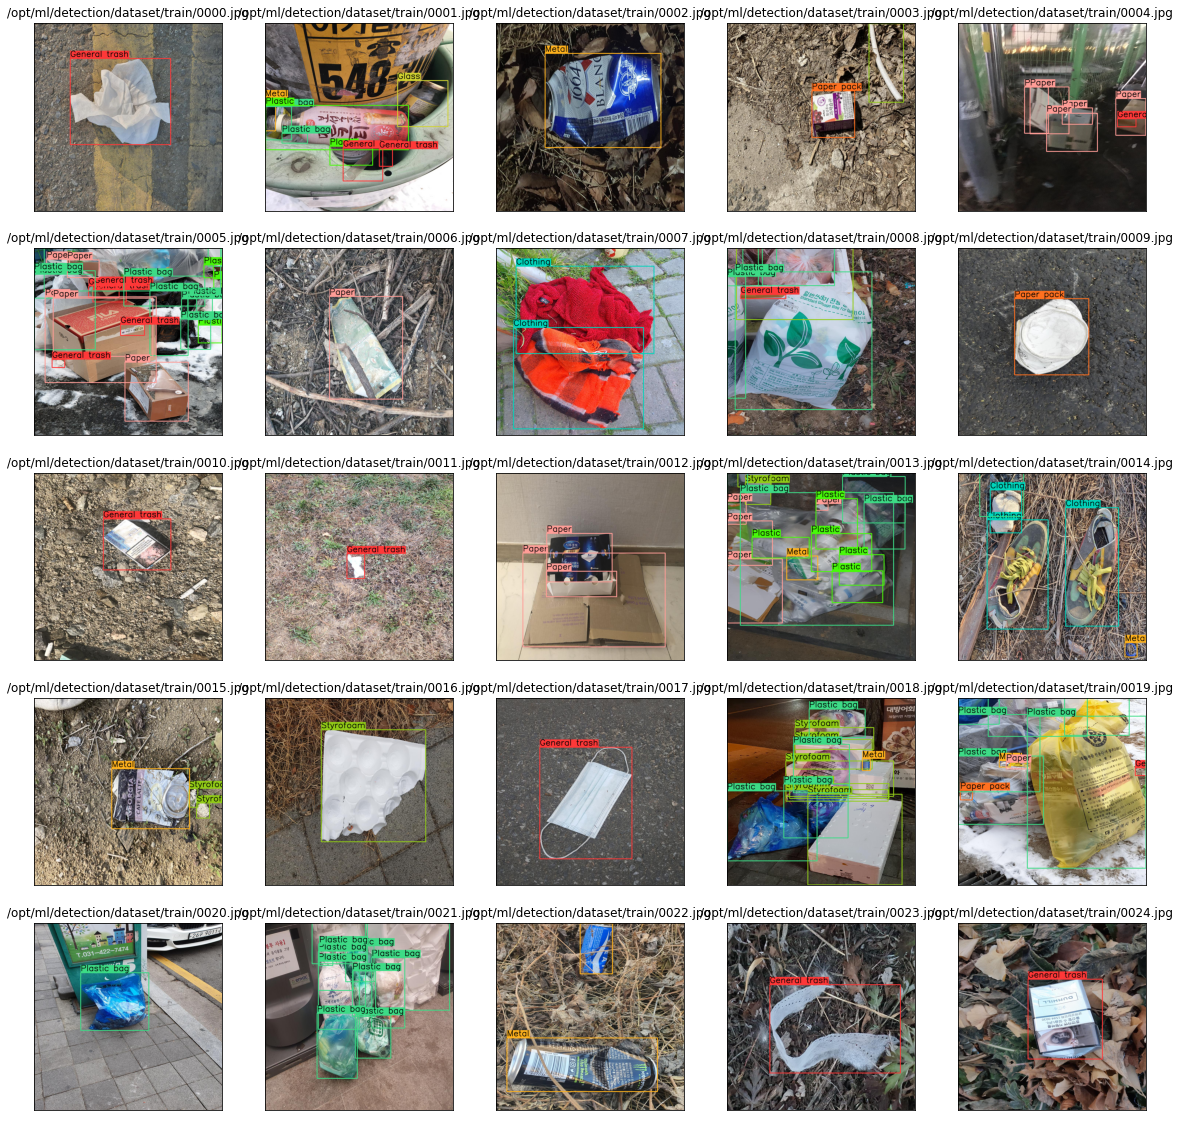

In [7]:
from pycocotools.coco import COCO

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches


anno_root = '/opt/ml/detection/dataset/train.json' # annotation root
data_dir = '/opt/ml/detection/dataset' # data directory root

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_annos, image_labels = [], [], []
for i in range(len(images)):
    image_info = coco.loadImgs(i)[0]
    image_paths.append(os.path.join(data_dir, image_info['file_name']))
    anno_ids = coco.getAnnIds(imgIds=image_info['id'])
    anno = coco.loadAnns(anno_ids)
    image_annos.append(get_bbox(anno))
    image_labels.append(get_cat(anno))

start = 0
frame_lst = []
anno_lst = image_annos[start:start+25]
label_lst = image_labels[start:start+25]
path_lst = image_paths[start:start+25]
for i in range(len(image_paths[start:start+25])):
    frame = np.array(Image.open(image_paths[i]))
    frame = draw_bbox(frame, anno_lst[i], label_lst[i])
    frame_lst.append(frame)

n, m = 5, 5
fig, axes = plt.subplots(n, m, figsize=(m*4, n*4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frame_lst[i])
    ax.set_title(path_lst[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


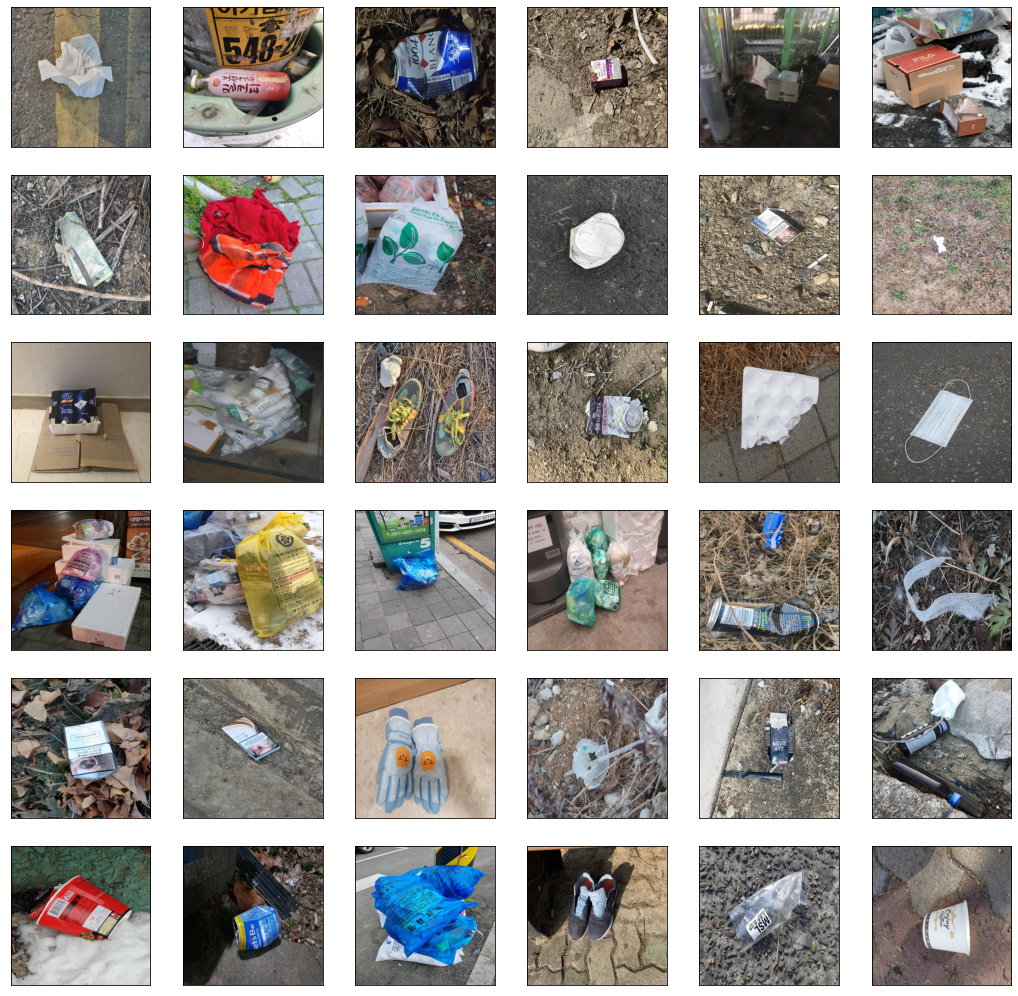

In [8]:
anno_root = '/opt/ml/detection/dataset/train.json' # annotation root
data_dir = '/opt/ml/detection/dataset' # data directory root

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_annos = [], []
for i in range(len(images)):
    image_info = coco.loadImgs(i)[0]
    image_paths.append(os.path.join(data_dir, image_info['file_name']))

start = 0
img_lst = []
anno_lst = image_annos[start:start+36]
for image_path in image_paths[start:start+36]:
    img = Image.open(image_path)
    img_lst.append(img)

n, m = 6, 6
fig, axes = plt.subplots(n, m, figsize=(m*3, n*3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(img_lst[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


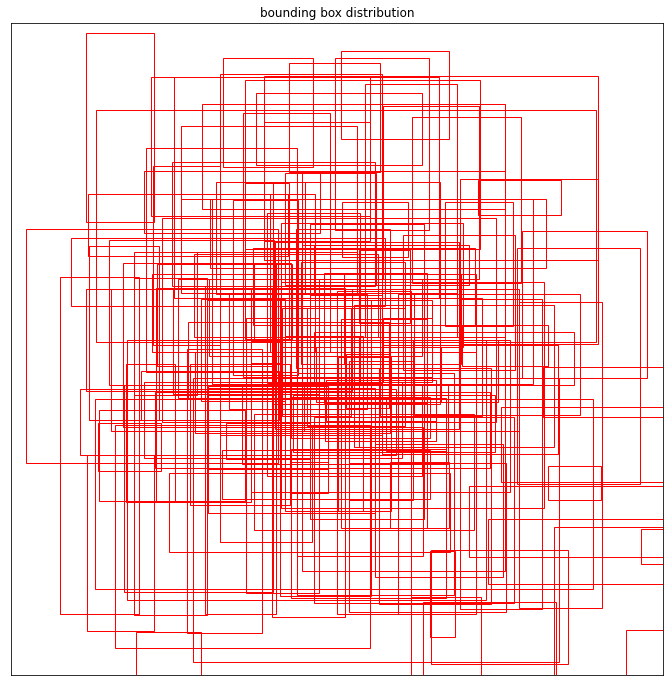

In [9]:
label_list = {'0': 'General trash', '1': 'Paper', '2': 'Paper pack', '3': 'Metal', '4': 'Glass', '5': 'Plastic', '6': 'Styrofoam', '7': 'Plastic bag', '8': 'Battery', '9': 'Clothing'}

anno_root = '/opt/ml/detection/dataset/train.json' # annotation root
data_dir = '/opt/ml/detection/dataset' # data directory root

coco = COCO(anno_root)

images = coco.dataset["images"].copy()
image_paths, image_annos, image_labels = [], [], []
for i in range(len(images)):
    image_info = coco.loadImgs(i)[0]
    image_paths.append(os.path.join(data_dir, image_info['file_name']))
    anno_ids = coco.getAnnIds(imgIds=image_info['id'])
    anno = coco.loadAnns(anno_ids)
    image_annos.append(get_bbox(anno))
    image_labels.append(get_cat(anno))

background = np.empty((1024, 1024, 3))
background.fill(255)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(background)
ax.set_title('bounding box distribution')
for i in range(len(image_labels)):
    for j in range(len(image_labels[i])):
        if image_labels[i][j] == 'Battery':
            ax.add_patch(get_patch(image_annos[i][j]))
ax.set_xticks([])
ax.set_yticks([])
plt.show()